In [2]:
import numpy, cv2, time
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import sparse
#from math import log10, sqrt
from JokeFunc import GrayImg, LinSys
from importlib import reload
GrayImg = reload(GrayImg)
LinSys = reload(LinSys)

# Read an image

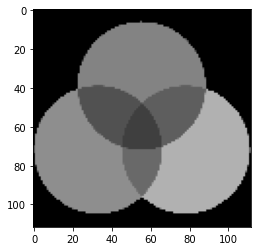

In [3]:
source = r'C:\Users\Admin\Jupyter\Image\3circle.png'
org_img = cv2.imread(source,64)
plt.imshow(org_img , cmap='gray', vmin=0, vmax=255)

# Adding noise

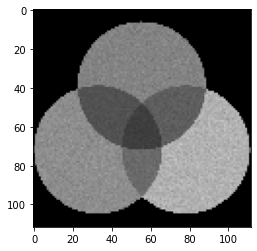

In [11]:
# Adding noise
noisy_img = GrayImg.addnoise(org_img,std=1,per=5/100)
plt.imshow(noisy_img , cmap='gray', vmin=0, vmax=255)

# Denoising Image by diffusion SOR

In [19]:
t1 = time.time()

shape = noisy_img.shape
if len(shape)!=2:
    print('please enter a gray scale image')
m, n = shape
A = GrayImg.diffusion_array(shape,alpha=1)
b = noisy_img.reshape(noisy_img.size)
x = LinSys.CG(A,b,eps=1e-5)
denoise_diff_img = numpy.uint8(x.reshape(m,n))

t2 = time.time()
psnr1 = cv2.PSNR(org_img,noisy_img)
psnr2 = cv2.PSNR(org_img,denoise_diff_img)
print(psnr1,psnr2,'time',t2-t1)

1 11518.354827080122 res= 0.46289801082850973
2 1109.0702597165437 res= 0.15417136527584346
3 436.37873412442804 res= 0.067760212180105
4 232.65635673468142 res= 0.03376817175509861
5 115.6719807937368 res= 0.01652362999454061
6 59.228288508697965 res= 0.008278663332475521
7 29.294906989668192 res= 0.004148172360834869
8 14.857992267831733 res= 0.0020878667145158352
9 7.372852233740721 res= 0.0010389076557765487
10 3.755265129570263 res= 0.0005216294849426439
11 1.8717674905024408 res= 0.00026411866027576666
12 0.9638136661911841 res= 0.00013309003373208924
max time ~ 845.7012090682983
13 0.47241623753425427 res= 6.527905850688175e-05
14 0.2333876752189593 res= 3.2855828150460077e-05
15 0.11784007478326018 res= 1.6401375769575054e-05
16 0.05842313936399192 res= 8.140923615701398e-06
solution converges
33.25681329595098 26.72596067655892 time 1.9573211669921875


# Compare

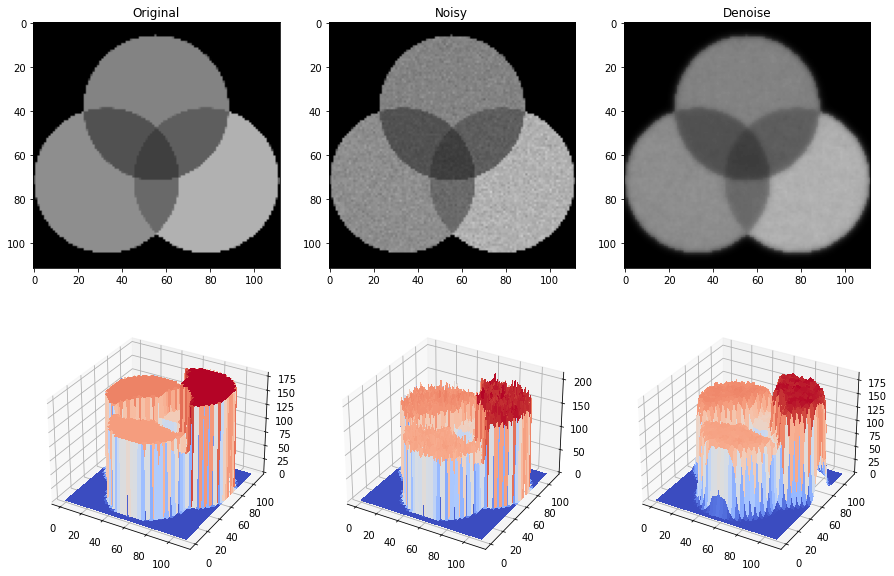

In [20]:
m,n = org_img.shape
X = numpy.arange(0,m,1)
Y = numpy.arange(0,n,1)
X, Y = numpy.meshgrid(X, Y)
fig = plt.figure(figsize=(15,10))
fig.add_subplot(2,3,1)
plt.title('Original')
plt.imshow(org_img , cmap='gray', vmin=0, vmax=255)
fig.add_subplot(2,3,2)
plt.title('Noisy')
plt.imshow(noisy_img , cmap='gray', vmin=0, vmax=255)
fig.add_subplot(2,3,3)
plt.title('Denoise')
plt.imshow(denoise_diff_img , cmap='gray', vmin=0, vmax=255)
oiax = fig.add_subplot(234,projection='3d')
oiax.plot_surface(X, Y, org_img, cmap=cm.coolwarm,linewidth=0, antialiased=False)
niax = fig.add_subplot(235,projection='3d')
niax.plot_surface(X, Y, noisy_img, cmap=cm.coolwarm,linewidth=0, antialiased=False)
diax = fig.add_subplot(236,projection='3d')
diax.plot_surface(X, Y, denoise_diff_img, cmap=cm.coolwarm,linewidth=0, antialiased=False)
plt.show()

# Denoising Image by TV ETM

In [30]:
t1 = time.time()

shape = noisy_img.shape
if len(shape)!=2:
    print('please enter a gray scale image')
Imax=10000
alpha=5
beta=1e-3
tau=5e-3
eps=1e-6

m, n = shape
z = noisy_img
u = numpy.float32(numpy.copy(z))

normU = numpy.zeros((m,n))
ux = numpy.append((u[1:,:]-u[:-1,:]),numpy.zeros((1,n)),0) #forward
uy = numpy.append((u[:,1:]-u[:,:-1]),numpy.zeros((m,1)),1) #forward
normU = (ux**2+uy**2+beta)**(0.5)
a = ux/normU
b = uy/normU
a = numpy.append(numpy.zeros((1,n)),a,0)
b = numpy.append(numpy.zeros((m,1)),b,1)
ax = a[1:,:]-a[:-1,:] #backward
by = b[:,1:]-b[:,:-1] #backward
K = ax+by

r = z-u+alpha*K
res0 = numpy.linalg.norm(r)

for k in range(Imax):
    u_old = numpy.copy(u)

    normU = numpy.zeros((m,n))
    ux = numpy.append((u[1:,:]-u[:-1,:]),numpy.zeros((1,n)),0) #forward
    uy = numpy.append((u[:,1:]-u[:,:-1]),numpy.zeros((m,1)),1) #forward
    normU = (ux**2+uy**2+beta)**(0.5)

    a = ux/normU
    b = uy/normU
    a = numpy.append(numpy.zeros((1,n)),a,0)
    b = numpy.append(numpy.zeros((m,1)),b,1)
    ax = a[1:,:]-a[:-1,:] #backward
    by = b[:,1:]-b[:,:-1] #backward
    K = ax+by
    u = u+tau*(z-u+alpha*K)
    r = z-u_old+alpha*K

    diff = numpy.linalg.norm(u-u_old)
    res = numpy.linalg.norm(r)/res0
    if (k+1)%(Imax//20)==0:
        print(k+1,'diff = ',diff,'res = ',res)
    if diff<eps:
        print('solution dose not change')
        break
    if res<eps:
        print('solution converges')
        break
    if k==Imax-1:
        print('Exceed')
denoise_TV_ETM_img = numpy.uint8(numpy.clip(u,0,255))

t2 = time.time()
print(cv2.PSNR(org_img,noisy_img),cv2.PSNR(org_img,denoise_TV_ETM_img),'time',t2-t1)

500 diff =  3.9926486935700565 res =  0.8738308209891829
1000 diff =  3.9846828859139642 res =  0.872087424868415
1500 diff =  3.976128335054662 res =  0.8702151764503117
2000 diff =  3.9970321504458046 res =  0.8747901840622923
2500 diff =  4.044315684680357 res =  0.8851386551426531
3000 diff =  3.9698731913176286 res =  0.8688461761182914
3500 diff =  4.009972523632964 res =  0.8776223132561907
4000 diff =  4.022413801394498 res =  0.8803452104592501
4500 diff =  4.024633808890075 res =  0.8808310811484457
5000 diff =  4.028535803612968 res =  0.8816850714475895
5500 diff =  4.0127530120429125 res =  0.878230850760112
6000 diff =  4.022763874536152 res =  0.8804218274431747
6500 diff =  3.949408084042974 res =  0.8643671841347881
7000 diff =  4.024596154906726 res =  0.8808228402002146
7500 diff =  4.034732148539907 res =  0.8830412030760408
8000 diff =  4.001027343603613 res =  0.8756645717645508
8500 diff =  3.9989479558806056 res =  0.8752094771091966
9000 diff =  3.9333515978802

# Compare

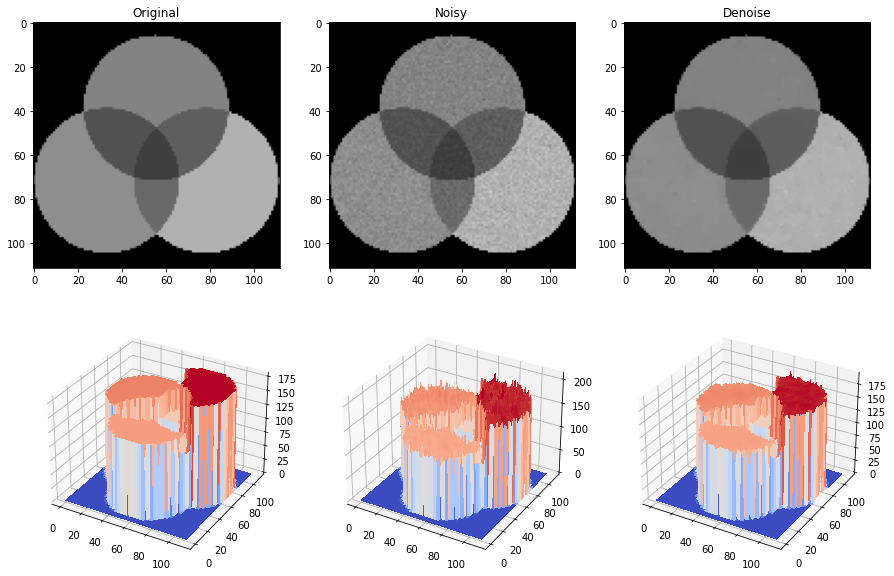

In [31]:
m,n = org_img.shape
X = numpy.arange(0,m,1)
Y = numpy.arange(0,n,1)
X, Y = numpy.meshgrid(X, Y)
fig = plt.figure(figsize=(15,10))
fig.add_subplot(2,3,1)
plt.title('Original')
plt.imshow(org_img , cmap='gray', vmin=0, vmax=255)
fig.add_subplot(2,3,2)
plt.title('Noisy')
plt.imshow(noisy_img , cmap='gray', vmin=0, vmax=255)
fig.add_subplot(2,3,3)
plt.title('Denoise')
plt.imshow(denoise_TV_ETM_img , cmap='gray', vmin=0, vmax=255)
oiax = fig.add_subplot(234,projection='3d')
oiax.plot_surface(X, Y, org_img, cmap=cm.coolwarm,linewidth=0, antialiased=False)
niax = fig.add_subplot(235,projection='3d')
niax.plot_surface(X, Y, noisy_img, cmap=cm.coolwarm,linewidth=0, antialiased=False)
diax = fig.add_subplot(236,projection='3d')
diax.plot_surface(X, Y, denoise_TV_ETM_img, cmap=cm.coolwarm,linewidth=0, antialiased=False)
plt.show()

# Denoising Image by TV SITM with SOR

In [40]:
t1 = time.time()

shape = noisy_img.shape
if len(shape)!=2:
    print('please enter a gray scale image')
Imax=100
alpha=5
beta=1e-3
tau=1e-2
eps=1e-6

m, n = shape
z = noisy_img
u = numpy.float32(numpy.copy(z))

normU = numpy.zeros((m,n))
ux = numpy.append((u[1:,:]-u[:-1,:]),numpy.zeros((1,n)),0) #forward
uy = numpy.append((u[:,1:]-u[:,:-1]),numpy.zeros((m,1)),1) #forward
normU = (ux**2+uy**2+beta)**(0.5)
a = ux/normU
b = uy/normU
a = numpy.append(numpy.zeros((1,n)),a,0)
b = numpy.append(numpy.zeros((m,1)),b,1)
ax = a[1:,:]-a[:-1,:] #backward
by = b[:,1:]-b[:,:-1] #backward
K = ax+by
r = z-u+alpha*K
res0 = numpy.linalg.norm(r)

for k in range(Imax):
    u_old = numpy.copy(u)

    normU = numpy.zeros((m,n))
    ux = numpy.append((u[1:,:]-u[:-1,:]),numpy.zeros((1,n)),0)
    uy = numpy.append((u[:,1:]-u[:,:-1]),numpy.zeros((m,1)),1)
    normU = (ux**2+uy**2+beta)**(1/2)
    Du = normU**(-1)
    
    Ku = -tau*alpha*numpy.append(numpy.zeros((1,n)),Du[:-1,:],0)
    Kl = -tau*alpha*numpy.append(numpy.zeros((m,1)),Du[:,:-1],1)
    Kr = -tau*alpha*numpy.append(Du[:,:-1],numpy.zeros((m,1)),1)
    Kd = -tau*alpha*numpy.append(Du[:-1,:],numpy.zeros((1,n)),0)
    Kc = 1+tau-Ku-Kl-Kr-Kd
    Kc = Kc.reshape(m*n)
    Ku = Ku.reshape(m*n)[n:]
    Kl = Kl.reshape(m*n)[1:]
    Kr = Kr.reshape(m*n)[:-1]
    Kd = Kd.reshape(m*n)[:-n]
    A = sparse.diags([Kc,Ku,Kl,Kr,Kd],[0,-n,-1,1,n]) #sparse form
    zb = (u+tau*z).reshape(z.size)
    
    u = LinSys.CG(A.toarray(),zb,x0=u_old.reshape(zb.shape),Imax=10)
    u = u.reshape(m,n)

    normU = numpy.zeros((m,n))
    ux = numpy.append((u[1:,:]-u[:-1,:]),numpy.zeros((1,n)),0) #forward
    uy = numpy.append((u[:,1:]-u[:,:-1]),numpy.zeros((m,1)),1) #forward
    normU = (ux**2+uy**2+beta)**(0.5)
    a = ux/normU
    b = uy/normU
    a = numpy.append(numpy.zeros((1,n)),a,0)
    b = numpy.append(numpy.zeros((m,1)),b,1)
    ax = a[1:,:]-a[:-1,:] #backward
    by = b[:,1:]-b[:,:-1] #backward
    K = ax+by
    r = z-u+alpha*K
    
    diff = numpy.linalg.norm(u-u_old)
    res = numpy.linalg.norm(r)/res0
    if (k+1)%(2)==0:
        print(k+1,'diff = ',diff,'res = ',res)
    if diff<eps:
        print('solution dose not change')
        break
    if res<eps:
        print('solution converges')
        break
    if k==Imax-1:
        print('Exceed')
    denoise_TV_SITM_img = numpy.uint8(numpy.clip(u,0,255))
    print('PSNR_noise',cv2.PSNR(org_img,noisy_img),'PSNR_denoise',cv2.PSNR(org_img,denoise_TV_SITM_img))
t2 = time.time()
print(cv2.PSNR(org_img,noisy_img),cv2.PSNR(org_img,denoise_TV_SITM_img),'time',t2-t1)

exceed iteration
PSNR_noise 33.25681329595098 PSNR_denoise 33.57666134852705
solution converges
2 diff =  8.641818147075728 res =  0.9692205551359093
PSNR_noise 33.25681329595098 PSNR_denoise 33.57714665747247
solution converges
PSNR_noise 33.25681329595098 PSNR_denoise 33.57781404583481
solution converges
4 diff =  8.40663475571641 res =  0.9437134560934122
PSNR_noise 33.25681329595098 PSNR_denoise 33.578967049170835
solution converges
PSNR_noise 33.25681329595098 PSNR_denoise 33.57929480072643
solution converges
6 diff =  8.17343111240197 res =  0.9184857133725365
PSNR_noise 33.25681329595098 PSNR_denoise 33.580120358697656
solution converges
PSNR_noise 33.25681329595098 PSNR_denoise 33.79879128289612
solution converges
8 diff =  7.941346097898736 res =  0.8931141064787644
PSNR_noise 33.25681329595098 PSNR_denoise 33.96700456605353
solution converges
PSNR_noise 33.25681329595098 PSNR_denoise 34.07786991584502
solution converges
10 diff =  7.711107978661219 res =  0.8677344221831393
P

exceed iteration
PSNR_noise 33.25681329595098 PSNR_denoise 38.52006000459048
exceed iteration
80 diff =  2.6226888481692185 res =  0.30069643705332366
PSNR_noise 33.25681329595098 PSNR_denoise 38.56203070948354
exceed iteration
PSNR_noise 33.25681329595098 PSNR_denoise 38.61318449708543
exceed iteration
82 diff =  2.54672995322793 res =  0.2920751410331029
PSNR_noise 33.25681329595098 PSNR_denoise 38.65681183892122
exceed iteration
PSNR_noise 33.25681329595098 PSNR_denoise 38.697172537606306
exceed iteration
84 diff =  2.4733038376505667 res =  0.28372830549648387
PSNR_noise 33.25681329595098 PSNR_denoise 38.73978360708986
exceed iteration
PSNR_noise 33.25681329595098 PSNR_denoise 38.77473820058655
exceed iteration
86 diff =  2.402468419635709 res =  0.2756711755083769
PSNR_noise 33.25681329595098 PSNR_denoise 38.81341877596408
exceed iteration
PSNR_noise 33.25681329595098 PSNR_denoise 38.851098123569415
exceed iteration
88 diff =  2.3340594024121515 res =  0.2678250868082428
PSNR_nois

# Compare

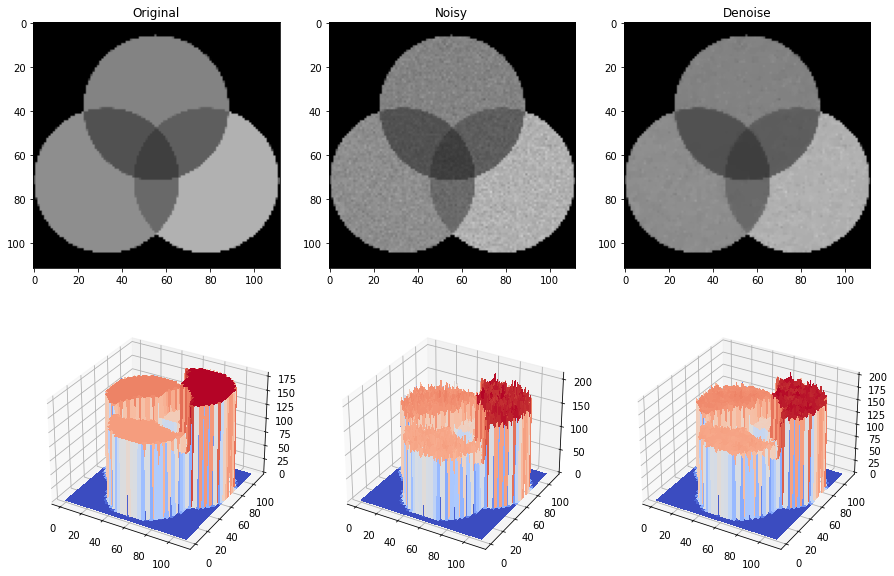

In [41]:
m,n = org_img.shape
X = numpy.arange(0,m,1)
Y = numpy.arange(0,n,1)
X, Y = numpy.meshgrid(X, Y)
fig = plt.figure(figsize=(15,10))
fig.add_subplot(2,3,1)
plt.title('Original')
plt.imshow(org_img , cmap='gray', vmin=0, vmax=255)
fig.add_subplot(2,3,2)
plt.title('Noisy')
plt.imshow(noisy_img , cmap='gray', vmin=0, vmax=255)
fig.add_subplot(2,3,3)
plt.title('Denoise')
plt.imshow(denoise_TV_SITM_img , cmap='gray', vmin=0, vmax=255)
oiax = fig.add_subplot(234,projection='3d')
oiax.plot_surface(X, Y, org_img, cmap=cm.coolwarm,linewidth=0, antialiased=False)
niax = fig.add_subplot(235,projection='3d')
niax.plot_surface(X, Y, noisy_img, cmap=cm.coolwarm,linewidth=0, antialiased=False)
diax = fig.add_subplot(236,projection='3d')
diax.plot_surface(X, Y, denoise_TV_SITM_img, cmap=cm.coolwarm,linewidth=0, antialiased=False)
plt.show()

# Denoising Image by TV FP with SOR

In [47]:
t1 = time.time()

shape = noisy_img.shape
if len(shape)!=2:
    print('please enter a gray scale image')
Imax=100
alpha=5
beta=1e-3
eps=1e-6

m, n = shape
z = noisy_img
u = numpy.float32(numpy.copy(z))
B = z.reshape(z.size)

normU = numpy.zeros((m,n))
ux = numpy.append((u[1:,:]-u[:-1,:]),numpy.zeros((1,n)),0) #forward
uy = numpy.append((u[:,1:]-u[:,:-1]),numpy.zeros((m,1)),1) #forward
normU = (ux**2+uy**2+beta)**(0.5)
a = ux/normU
b = uy/normU
a = numpy.append(numpy.zeros((1,n)),a,0)
b = numpy.append(numpy.zeros((m,1)),b,1)
ax = a[1:,:]-a[:-1,:] #backward
by = b[:,1:]-b[:,:-1] #backward
K = ax+by
r = z-u+alpha*K
res0 = numpy.linalg.norm(r)

for k in range(Imax):
    u_old = numpy.copy(u)

    normU = numpy.zeros((m,n))
    ux = numpy.append((u[1:,:]-u[:-1,:]),numpy.zeros((1,n)),0)
    uy = numpy.append((u[:,1:]-u[:,:-1]),numpy.zeros((m,1)),1)
    normU = (ux**2+uy**2+beta)**(1/2)
    Du = normU**(-1)
    
    Ku = -alpha*numpy.append(numpy.zeros((1,n)),Du[:-1,:],0)
    Kl = -alpha*numpy.append(numpy.zeros((m,1)),Du[:,:-1],1)
    Kr = -alpha*numpy.append(Du[:,:-1],numpy.zeros((m,1)),1)
    Kd = -alpha*numpy.append(Du[:-1,:],numpy.zeros((1,n)),0)
    Kc = 1-Ku-Kl-Kr-Kd
    Kc = Kc.reshape(m*n)
    Ku = Ku.reshape(m*n)[n:]
    Kl = Kl.reshape(m*n)[1:]
    Kr = Kr.reshape(m*n)[:-1]
    Kd = Kd.reshape(m*n)[:-n]
    A = sparse.diags([Kc,Ku,Kl,Kr,Kd],[0,-n,-1,1,n]) #sparse form
    
    u = LinSys.SOR(A.toarray(),B,x0=u_old.reshape(B.shape),Imax=3)
    u = u.reshape(m,n)
    
    normU = numpy.zeros((m,n))
    ux = numpy.append((u[1:,:]-u[:-1,:]),numpy.zeros((1,n)),0) #forward
    uy = numpy.append((u[:,1:]-u[:,:-1]),numpy.zeros((m,1)),1) #forward
    normU = (ux**2+uy**2+beta)**(0.5)
    a = ux/normU
    b = uy/normU
    a = numpy.append(numpy.zeros((1,n)),a,0)
    b = numpy.append(numpy.zeros((m,1)),b,1)
    ax = a[1:,:]-a[:-1,:] #backward
    by = b[:,1:]-b[:,:-1] #backward
    K = ax+by
    r = z-u+alpha*K
    
    diff = numpy.linalg.norm(u-u_old)
    res = numpy.linalg.norm(r)/res0
    if (k+1)%(1)==0:
        print(k+1,'diff = ',diff,'res = ',res)
    if diff<eps:
        print('solution dose not change')
        break
    if res<eps:
        print('solution converges')
        break
    if k==Imax-1:
        print('It\'s not converge')
    denoise_TV_FP_img = numpy.uint8(numpy.clip(u,0,255))
    print('PSNR_noise',cv2.PSNR(org_img,noisy_img),'PSNR_denoise',cv2.PSNR(org_img,denoise_TV_FP_img))
t2 = time.time()
print(cv2.PSNR(org_img,noisy_img),cv2.PSNR(org_img,denoise_TV_FP_img),"time",t2-t1)

SOR exceed iteration
1 diff =  334.02056287946726 res =  0.5513423533407837
PSNR_noise 33.25681329595098 PSNR_denoise 37.53380168081102
SOR exceed iteration
2 diff =  97.39803646199042 res =  0.39307424345783326
PSNR_noise 33.25681329595098 PSNR_denoise 39.189893974953605
SOR exceed iteration
3 diff =  45.51502805764647 res =  0.31255428663211704
PSNR_noise 33.25681329595098 PSNR_denoise 40.00060489010554
SOR exceed iteration
4 diff =  26.460197975535316 res =  0.2606959836613343
PSNR_noise 33.25681329595098 PSNR_denoise 40.46554652226173
SOR exceed iteration
5 diff =  17.67084330629301 res =  0.22429249177632526
PSNR_noise 33.25681329595098 PSNR_denoise 40.73171137432283
SOR exceed iteration
6 diff =  13.080586686185628 res =  0.19815600445327478
PSNR_noise 33.25681329595098 PSNR_denoise 40.90573140726449
SOR exceed iteration
7 diff =  10.589850900943155 res =  0.17612673226844702
PSNR_noise 33.25681329595098 PSNR_denoise 41.02610308210263
SOR exceed iteration
8 diff =  8.492114366711

SOR exceed iteration
61 diff =  0.1490055119032132 res =  0.07932570833747124
PSNR_noise 33.25681329595098 PSNR_denoise 41.32324097838536
SOR exceed iteration
62 diff =  0.14908545694713768 res =  0.07931945792017416
PSNR_noise 33.25681329595098 PSNR_denoise 41.32251894729107
SOR exceed iteration
63 diff =  0.14803516090951008 res =  0.07929589074084384
PSNR_noise 33.25681329595098 PSNR_denoise 41.32316876987388
SOR exceed iteration
64 diff =  0.14222007105997644 res =  0.07925934923127843
PSNR_noise 33.25681329595098 PSNR_denoise 41.32309656256295
SOR exceed iteration
65 diff =  0.1332763832198401 res =  0.07923760172647001
PSNR_noise 33.25681329595098 PSNR_denoise 41.322952151542644
SOR exceed iteration
66 diff =  0.12233280974660578 res =  0.0792268803349097
PSNR_noise 33.25681329595098 PSNR_denoise 41.322735544015394
SOR exceed iteration
67 diff =  0.13048389775016253 res =  0.07919210211038302
PSNR_noise 33.25681329595098 PSNR_denoise 41.322591144998924
SOR exceed iteration
68 dif

# Compare

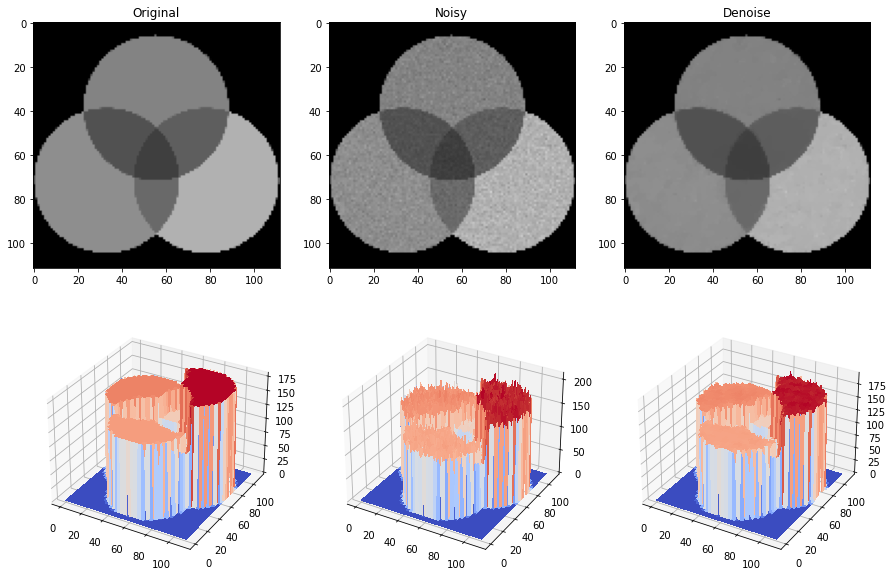

In [48]:
m,n = org_img.shape
X = numpy.arange(0,m,1)
Y = numpy.arange(0,n,1)
X, Y = numpy.meshgrid(X, Y)
fig = plt.figure(figsize=(15,10))
fig.add_subplot(2,3,1)
plt.title('Original')
plt.imshow(org_img , cmap='gray', vmin=0, vmax=255)
fig.add_subplot(2,3,2)
plt.title('Noisy')
plt.imshow(noisy_img , cmap='gray', vmin=0, vmax=255)
fig.add_subplot(2,3,3)
plt.title('Denoise')
plt.imshow(denoise_TV_FP_img , cmap='gray', vmin=0, vmax=255)
oiax = fig.add_subplot(234,projection='3d')
oiax.plot_surface(X, Y, org_img, cmap=cm.coolwarm,linewidth=0, antialiased=False)
niax = fig.add_subplot(235,projection='3d')
niax.plot_surface(X, Y, noisy_img, cmap=cm.coolwarm,linewidth=0, antialiased=False)
diax = fig.add_subplot(236,projection='3d')
diax.plot_surface(X, Y, denoise_TV_FP_img, cmap=cm.coolwarm,linewidth=0, antialiased=False)
plt.show()